In [ ]:
!pip install torch torchvision torchaudio
!pip install albumentations opencv-python-headless

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

In [ ]:
# 구글 드라이브를 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터셋 준비
data_dir = '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset'

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

# 데이터 로드
train_df = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/TrainData.csv')
valid_df = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/ValidData.csv')
test_df = pd.read_csv('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/TestData.csv')

# 데이터 경로 설정
image_path = "/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/dataset/images"

# Label Encoding
le = LabelEncoder()
train_df['Class'] = le.fit_transform(train_df['Class'])
valid_df['Class'] = le.transform(valid_df['Class'])
test_df['Class'] = le.transform(test_df['Class'])


In [ ]:
le.classes_

array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'], dtype=object)

In [ ]:
class SkinDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0]) + ".jpg"
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SkinDataset(train_df, image_path, transform=transform)
valid_dataset = SkinDataset(valid_df, image_path, transform=transform)
test_dataset = SkinDataset(test_df, image_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 25
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_acc = correct.double() / len(valid_loader.dataset)
    valid_losses.append(epoch_loss)
    valid_accuracies.append(epoch_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {valid_losses[-1]:.4f}, Val Acc: {valid_accuracies[-1]:.4f}')

# 모델 저장
torch.save(model.state_dict(), '/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/resnet18_cls_V1.pth')


Epoch 1/25, Train Loss: 0.7716, Train Acc: 0.7336, Val Loss: 0.6655, Val Acc: 0.7580
Epoch 2/25, Train Loss: 0.5359, Train Acc: 0.8065, Val Loss: 0.7565, Val Acc: 0.7160
Epoch 3/25, Train Loss: 0.4456, Train Acc: 0.8328, Val Loss: 0.6249, Val Acc: 0.7910
Epoch 4/25, Train Loss: 0.3581, Train Acc: 0.8722, Val Loss: 0.6140, Val Acc: 0.7930
Epoch 5/25, Train Loss: 0.2777, Train Acc: 0.8958, Val Loss: 0.6035, Val Acc: 0.8010
Epoch 6/25, Train Loss: 0.1970, Train Acc: 0.9295, Val Loss: 0.8437, Val Acc: 0.7890
Epoch 7/25, Train Loss: 0.1597, Train Acc: 0.9426, Val Loss: 0.8347, Val Acc: 0.7800
Epoch 8/25, Train Loss: 0.1193, Train Acc: 0.9559, Val Loss: 0.9441, Val Acc: 0.7890
Epoch 9/25, Train Loss: 0.1168, Train Acc: 0.9587, Val Loss: 0.9384, Val Acc: 0.7800
Epoch 10/25, Train Loss: 0.0575, Train Acc: 0.9803, Val Loss: 0.7688, Val Acc: 0.8180
Epoch 11/25, Train Loss: 0.0698, Train Acc: 0.9763, Val Loss: 1.0115, Val Acc: 0.8010
Epoch 12/25, Train Loss: 0.0474, Train Acc: 0.9845, Val Loss: 0

In [ ]:
!pip install pickle-mixin

  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5991 sha256=1104a0e67a3fcee4da99ff6913f2548a1711ca130a7dad4125cc51af320caae5
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [ ]:
import pickle

In [ ]:
# loss, accuracy 저장
# 학습 및 검증 loss와 accuracy 저장
with open('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/train_valid_metrics.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'train_accuracies': train_accuracies,
        'valid_accuracies': valid_accuracies
    }, f)

In [ ]:
# 학습 및 검증 결과 불러오기
with open('/content/drive/MyDrive/클라우드컴퓨팅 텀프로젝트/model/train_valid_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)
    train_losses = metrics['train_losses']
    valid_losses = metrics['valid_losses']
    train_accuracies = metrics['train_accuracies']
    valid_accuracies = metrics['valid_accuracies']

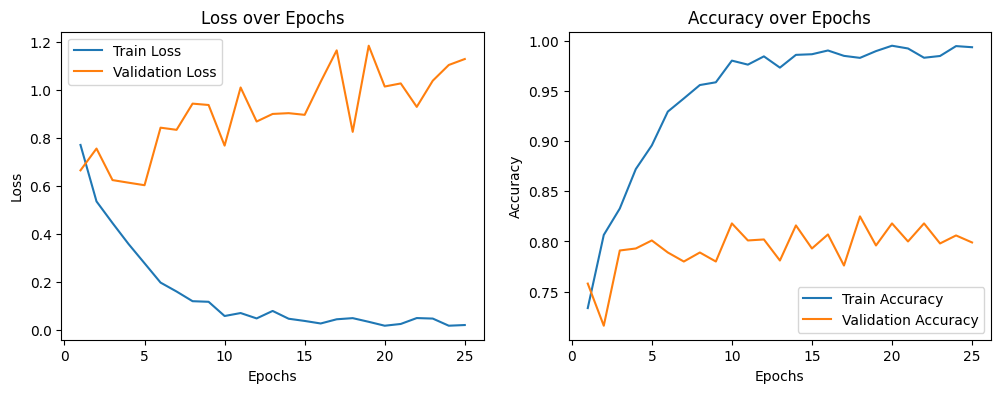

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [ ]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Class별 Accuracy
report = classification_report(all_labels, all_preds, target_names=le.classes_)
print('Classification Report:')
print(report)

Confusion Matrix:
[[  9   1  14   2   2   5   0]
 [  6  18  11  11   2   4   0]
 [  1   1  81   3   4  20   0]
 [  0   1   1   8   1   1   0]
 [  1   0  24   4  27  56   0]
 [  0   0  22   7   4 638   0]
 [  0   1   1   1   0   4   8]]
Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.53      0.27      0.36        33
         BCC       0.82      0.35      0.49        52
         BKL       0.53      0.74      0.61       110
          DF       0.22      0.67      0.33        12
         MEL       0.68      0.24      0.36       112
          NV       0.88      0.95      0.91       671
        VASC       1.00      0.53      0.70        15

    accuracy                           0.79      1005
   macro avg       0.66      0.54      0.54      1005
weighted avg       0.80      0.79      0.77      1005

